--2024-11-13 23:15:24--  https://storage.yandexcloud.net/academy.ai/CV/aerial_images.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4174531957 (3.9G) [application/x-zip-compressed]
Saving to: ‘aerial_images.zip.3’

aerial_images.zip.3 100%[===================>]   3.89G  29.5MB/s    in 2m 19s  

2024-11-13 23:17:44 (28.6 MB/s) - ‘aerial_images.zip.3’ saved [4174531957/4174531957]

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 215s 10s/step - accuracy: 0.5928 - loss: 1.2057 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
20

ValueError: Unsupported channel number: 24

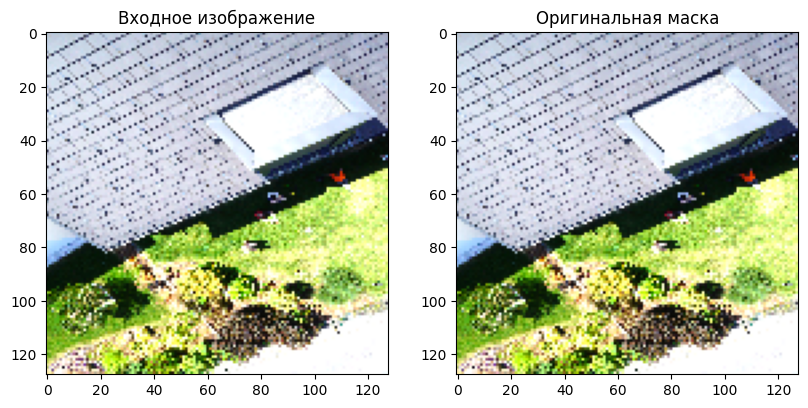

In [ ]:
# Установка необходимых библиотек
!pip install tensorflow keras albumentations

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, RandomBrightnessContrast,
    RandomGamma, RandomCrop, Resize
)

# Загрузка и распаковка датасета
!wget https://storage.yandexcloud.net/academy.ai/CV/aerial_images.zip
!unzip -qo "aerial_images.zip" -d ./dataset

dataset_path = './dataset/dataset/semantic_drone_dataset'
image_dir = 'original_images'
label_dir = 'label_images_semantic'

# Функция для отображения изображений и масок
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[0]))  # отображаем картинку
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.show()

# Загрузка и подготовка данных
images = []
masks = []

for img_name in os.listdir(os.path.join(dataset_path, image_dir)):
    img_path = os.path.join(dataset_path, image_dir, img_name)
    mask_path = os.path.join(dataset_path, label_dir, img_name.replace('.jpg', '.png'))
    images.append(tf.keras.utils.load_img(img_path, target_size=(128, 128), color_mode='rgb'))
    masks.append(tf.keras.utils.load_img(mask_path, target_size=(128, 128), color_mode='grayscale'))

images = np.array([tf.keras.utils.img_to_array(img) for img in images])
masks = np.array([tf.keras.utils.img_to_array(mask) for mask in masks])

# Нормализация данных
images = images / 255.0
masks = masks / 255.0

# Преобразование масок в формат one-hot encoding
num_classes = 24  # 24 класса объектов
masks = np.squeeze(masks, axis=-1)  # Удаляем последнюю размерность
masks = to_categorical(masks, num_classes)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Аугментация данных с использованием Albumentations
def augment_data(images, masks, augmentations):
    augmented_images = []
    augmented_masks = []
    for img, mask in zip(images, masks):
        augmented = augmentations(image=img, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])
    return np.array(augmented_images), np.array(augmented_masks)

augmentations = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    RandomBrightnessContrast(p=0.2),
    RandomGamma(p=0.2),
    RandomCrop(height=128, width=128, p=1.0),
    Resize(height=128, width=128, p=1.0)
])

X_train, y_train = augment_data(X_train, y_train, augmentations)
X_test, y_test = augment_data(X_test, y_test, augmentations)

# Определение архитектуры U-Net с уменьшенным количеством фильтров
def encoder(inputs, filters):
    conv1 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    return conv2, pool

def decoder(inputs, skip, filters):
    up = Conv2D(filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(inputs))
    merge = concatenate([skip, up], axis=3)
    conv1 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv2 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    return conv2

def U_Net(img_size, num_classes):
    inputs = Input(img_size)

    skip1, encoder_1 = encoder(inputs, 32)
    skip2, encoder_2 = encoder(encoder_1, 64)
    skip3, encoder_3 = encoder(encoder_2, 128)
    skip4, encoder_4 = encoder(encoder_3, 256)

    conv_block = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(encoder_4)
    conv_block = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_block)

    decoder_1 = decoder(conv_block, skip4, 256)
    decoder_2 = decoder(decoder_1, skip3, 128)
    decoder_3 = decoder(decoder_2, skip2, 64)
    decoder_4 = decoder(decoder_3, skip1, 32)

    outputs = Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)  # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes)  # инициализируем модель

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Обучение модели с использованием коллбэка для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=5,
          batch_size=16,
          callbacks=callbacks)

# Предсказание и визуализация результатов
predictions = model.predict(X_test, verbose=1)

n = 5
for i in range(n):
    display([X_test[i], y_test[i], predictions[i]])